# Kaggle Global-Wheat-Detection Dataset <a class="anchor" id="top"></a>

https://www.kaggle.com/c/global-wheat-detection

## Table of Content
* [Image Helpers](#image_helpers)
* [Data Helpers](#data_helpers)
* [Prepare Data](#prepare_data)
* [Visualize Data](#visualize_data)
* [Augment Data](#augment_data)
* [Generate Model](#generate_model)
* [Train Model](#train_model)
* [Show Results](#show_results)

### Useful Notebooks (kudos!)
- Augmentations, Data Cleaning and Bounding Boxes  
  https://www.kaggle.com/reighns/augmentations-data-cleaning-and-bounding-boxes
- EfficientDet  
  https://www.kaggle.com/shonenkov/training-efficientdet


In [1]:
# Standard imports
import numpy as np
import os
import pandas as pd
import warnings

# User Variables <a class="anchor" id="user_variables"></a> 
[got to top](#top)

In [2]:
# User Variables
data_root = os.path.join(os.environ["HOME"], 'workspace', 'personal', 'plai', 'res', 'data') # Leave empty for upload on kaggle


# Image Helpers <a class="anchor" id="image_helpers"></a> 
[got to top](#top)


In [91]:
"""@package image_helpers

  @brief Helper functions to visualize images (e.g. bounding boxes)
  
  @author Maximilian Harr <maximilian.harr@gmail.com>
  @date 01.06.2020

  @bug
  @warning
  @todo
 
"""
## IMPORTS #######################################################################################
import cv2
import glob
import math
import numpy as np
import scipy.io
from skimage import io, exposure
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

## CLASSES #######################################################################################

class ImageHelper():
    """ Class for visualization / checking images. """
    
    def check_all_image_sizes(self, image_folder_path: str, width: int, height: int) -> bool:
        """
        check_all_image_sizes Check if all images in folder have a certain size
            @param image_folder_path: path to folder
            @param width, height: image dimension
            @return: boolean
        """
        
        # Check input parameters
        if not type(image_folder_path) == str or not type(width) == int or not type(height) == int:
            raise TypeError('Wrong datatype provided')
        if not os.path.isdir(image_folder_path):
            raise ValueError('Directory does not exist')
        
        # Check size of all images
        total_img_list = glob.glob(os.path.join(image_folder_path,"*"))
        counter = 0
        
        for image in tqdm(total_img_list, desc="Checking images"):
            try:
                img = cv2.imread(image)
                img_height, img_width = img.shape[1], img.shape[0]
            except AttributeError:
                if not (img_width == width and img_height == height):
                    counter = counter + 1
        return counter == 0
    
    def check_bbox(self, bbox: pd.DataFrame) -> bool:
        """
        check_bbox Checks if the boundingbox pandas frame bbox has all necessary columns
            @param bbox pandas datafram
            @return boolen
        """
        
        # Check input parameters
        if not type(bbox) == pd.DataFrame:
            raise TypeError('Wrong datatype provided')
        
        # Check if columns exist
        if set(['image_name', 'width', 'height', 'x_min', 'x_max', 'y_min', 'y_max', 'class']).issubset(bbox.columns):
            return True
        else:
            return False
    
    def check_image_and_bbox(self, image_folder_path: str, image_bbox_dataframe: pd.DataFrame) -> bool:
        """ 
        check_image_and_bbox Check image and bbox for consistency
            @param image_folder_path path to images
            @param image_bbox_dataframe pandas dataframe with images
            @return boolean
        """
    
        # Check input parameters
        if not type(image_folder_path) == str or not type(image_bbox_dataframe) == pd.DataFrame:
            raise TypeError('Wrong datatype provided')
        if not os.path.isdir(image_folder_path):
            raise ValueError('Directory does not exist')
        if not self.check_bbox(image_bbox_dataframe):
            raise ValueError('Dataframe is not a valid bbox dataframe')

        # Check if all images in image_bbox_dataframe are existent
        missing_images = []
        for image_name in image_bbox_dataframe['image_name'].unique():
            image_path = os.path.join(image_folder_path, image_name)
            if not os.path.isfile(image_path):
                missing_images.append(image_name)
        
        if len(missing_images) is not 0:
            warnings.warn("Images specified in Bbox are missing", UserWarning)
            print(missing_images)
            return False
        
        return True
    
    def plot_multiple_img(self, img_matrix_list: list, 
                          title_list: np.ndarray, 
                          ncols: int, 
                          main_title: str = ""):
        """
        plot_multiple_img Plots multiple images
            @param img_matrix_list list of images (cv2.imread)
            @param title_list 
            @param ncols number of plot columns
            @param main_title Title of plot
            @return
        """
        
        # Check input parameters
        if not type(img_matrix_list) == list \
            or not type(title_list) == np.ndarray \
            or not type(ncols) == int \
            or not type(main_title) == str:
            raise TypeError('Wrong datatype provided')
        
        
        fig, myaxes = plt.subplots(figsize=(20, 10), nrows=math.ceil(len(img_matrix_list)/ncols), 
                                   ncols=ncols, squeeze=False)
        fig.suptitle(main_title, fontsize = 30)
        fig.subplots_adjust(wspace=0.3)
        fig.subplots_adjust(hspace=0.3)
        for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
            myaxes[i // ncols][i % ncols].imshow(img)
            myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
        plt.show()
        
    def plot_random_images(self, image_folder_path: str, 
                           image_bbox_dataframe: pd.DataFrame, 
                           ncols: int = 2,
                           nimgs: int = 12) -> None:
        """
        plot_random_images Plots random images
            @param image_folder_path
            @param image_bbox_dataframe
            @param ncols number of coulums
            @param nimgs number of image
            @return
        """
        
        # Check input parameters
        if not type(image_folder_path) == str \
            or not type(image_bbox_dataframe) == pd.DataFrame \
            or not type(ncols) == int \
            or not type(nimgs) == int:
            raise TypeError('Wrong datatype provided')
        if not os.path.isdir(image_folder_path):
            raise ValueError('Directory does not exist')
        if not self.check_bbox(image_bbox_dataframe):
            raise ValueError('Dataframe is not a valid bbox dataframe')

        # randomly choose 12 images to plot
        img_files_list = np.random.choice(list(image_bbox_dataframe['image_name']), nimgs)
        print("The images' names are {}".format(img_files_list))
        img_matrix_list = []

        for img_file in img_files_list:
            image_file_path = os.path.join(image_folder_path, img_file)
            img = cv2.imread(image_file_path)[:,:,::-1]  
            img_matrix_list.append(img)

        return self.plot_multiple_img(img_matrix_list, title_list = img_files_list, ncols = ncols, main_title="Wheat Images")

    def plot_random_images_bbox(self, image_folder_path: str, 
                                image_bbox_dataframe: pd.DataFrame, 
                                ncols: int = 2,
                                nimgs: int = 12) -> None:
        """
        plot_random_images_bbox Plots random images with bounding boxes
            @param image_folder_path
            @param image_bbox_dataframe
            @param ncols number of coulums
            @param nimgs number of image
            @return
        """
        
        # Check input parameters
        if not type(image_folder_path) == str \
            or not type(image_bbox_dataframe) == pd.DataFrame \
            or not type(ncols) == int \
            or not type(nimgs) == int:
            raise TypeError('Wrong datatype provided')
        if not os.path.isdir(image_folder_path):
            raise ValueError('Directory does not exist')
        if not self.check_bbox(image_bbox_dataframe):
            raise ValueError('Dataframe is not a valid bbox dataframe')
            
        # randomly choose 12 image.
        img_files_list = np.random.choice(list(image_bbox_dataframe['image_name']), nimgs)
        print("The images' names are {}".format(img_files_list))
        image_file_path_list = []

        bbox_list = []
        img_matrix_list = []
        random_image_matrix_list = []
        
        # Save images and bounding boxes in new list
        for img_file in img_files_list:
            
            bbox_list.append( image_bbox_dataframe[image_bbox_dataframe['image_name'] == img_file] )
            
            image_file_path = os.path.join(image_folder_path, img_file)
            img = cv2.imread(image_file_path)[:,:,::-1]  
            img_matrix_list.append(img)
        
        # Plot all bounding boxes in image
        final_bbox_list = []
        for bboxes, img in zip(bbox_list, img_matrix_list):
            
            box = bboxes[['x_min','x_max', 'y_min', 'y_max']]
            random_image = img.copy()
            
            for bbox in bboxes[['x_min','y_min', 'x_max', 'y_max']].values.astype(int).reshape(-1, 4):
                start_point = tuple(np.array(bbox[0:2]))
                end_point = tuple(np.array(bbox[2:4]))
                color = (255, 0, 0)
                thickness = 2
                random_image = cv2.rectangle(random_image, start_point, end_point, color, thickness)
            
            random_image_matrix_list.append(random_image)
            
        self.plot_multiple_img(random_image_matrix_list, 
                               title_list = img_files_list, 
                               ncols=ncols, 
                               main_title="Bounding Box Wheat Images")   
    
## FUNCTIONS #####################################################################################


The images' names are ['b53afdf5c.jpg' 'b53afdf5c.jpg' 'b6ab77fd7.jpg' 'b6ab77fd7.jpg'
 'b53afdf5c.jpg' 'b6ab77fd7.jpg']


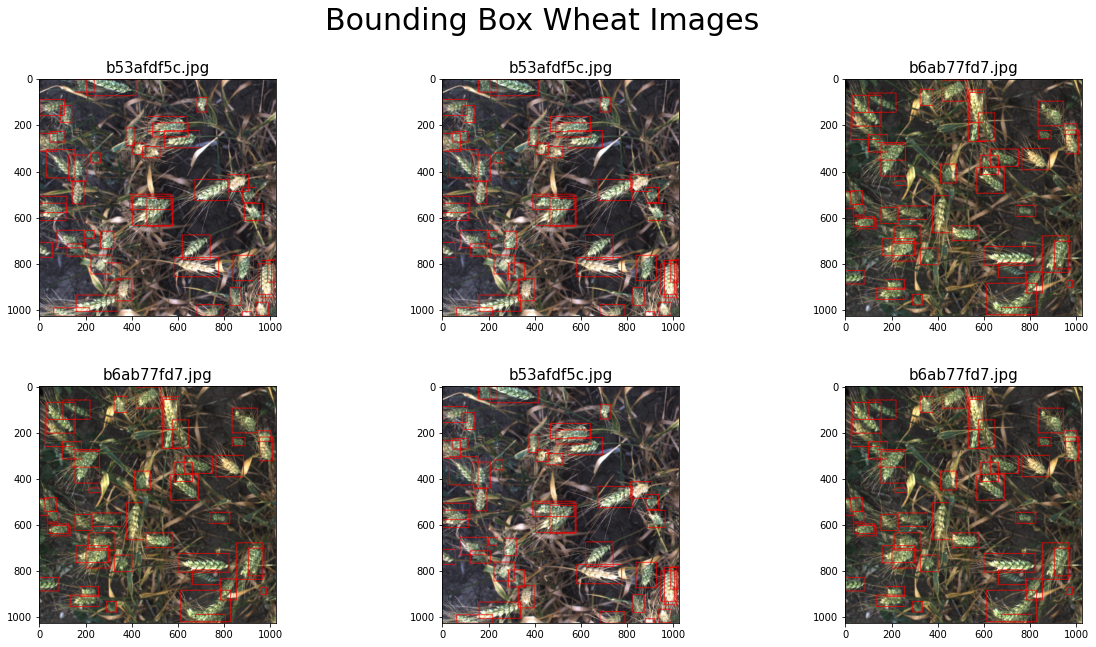

In [98]:
import plai.workspace.init

image_helper = ImageHelper()

plai_image_folder = os.path.join( plai.workspace.init.get_ws_path(), 'common', 'plai', 'test', 'res', 'imgs')

# Read Bbox annotation file
image_bbox = pd.DataFrame([])
image_bbox_csv = os.path.join( plai.workspace.init.get_ws_path(), 'common', 'plai', 'test', 'res', 'train.csv')

with open(image_bbox_csv, "r") as file:
    image_bbox = pd.read_csv(image_bbox_csv)


#ver_flip_img = image_helper.draw_rect_with_labels(img = ver_flip_annotations['image'], 
#                                                  bboxes = np.array(ver_flip_annotations['bboxes']),
#                                                  class_id = ver_flip_annotations['labels'], 
#                                                  class_dict = {0: "background",1: "wheat"}, 
#                                                  color=(255,0,0))
    
image_helper.plot_random_images_bbox(plai_image_folder, image_bbox, nimgs=6, ncols=3)

# @todo Continue work here

In [ ]:
"""@package test_image_helpers

  @brief Unittest for image helpers
  
  @author Maximilian Harr <maximilian.harr@gmail.com>
  @date 01.06.2020

  @bug
  @warning
  @todo
 
"""

# IMPORTS ########################################################################################
import unittest
import math
import numpy as np

# Local
import plai.workspace.init

# CLASSES ########################################################################################

class TestImageHelpers(unittest.TestCase):
    
    def test_check_all_image_sizes(self):
        
        image_helper = ImageHelper()
        
        plai_image_folder = os.path.join( plai.workspace.init.get_ws_path(), 'common', 'plai', 'test', 'res', 'imgs')
        
        self.assertEqual(True, image_helper.check_all_image_sizes(plai_image_folder, width=1024, height=1024) )
    
    def test_check_bbox(self):
        
        image_helper = ImageHelper()
        
        image_bbox = pd.DataFrame(
            [['*.jpg', 0, 0, 0, 0, 0, 0, 0],
            ['*.jpg', 0, 0, 0, 0, 0, 0, 0]],
            columns=['image_name', 'width', 'height', 'x_min', 'x_max', 'y_min', 'y_max', 'class'])
                
        self.assertEqual(True, image_helper.check_bbox(image_bbox))
        
    def test_check_image_and_bbox(self):
        
        image_helper = ImageHelper()
    
        plai_image_folder = os.path.join( plai.workspace.init.get_ws_path(), 'common', 'plai', 'test', 'res', 'imgs')
        image_bbox = pd.DataFrame(
            [['b53afdf5c.jpg', 1024, 1024, 0, 0, 0, 0, 0],
            ['b6ab77fd7.jpg', 1024, 1024, 0, 0, 0, 0, 0]],
            columns=['image_name', 'width', 'height', 'x_min', 'x_max', 'y_min', 'y_max', 'class'])
        
        self.assertEqual( True, image_helper.check_image_and_bbox(plai_image_folder, image_bbox))
        
        image_bbox = pd.DataFrame(
            [['missing_image.jpg', 1024, 1024, 0, 0, 0, 0, 0]],
            columns=['image_name', 'width', 'height', 'x_min', 'x_max', 'y_min', 'y_max', 'class'])
        
        self.assertEqual( False, image_helper.check_image_and_bbox(plai_image_folder, image_bbox))
    
    def test_plot_random_images(self):
        
        image_helper = ImageHelper()

        plai_image_folder = os.path.join( plai.workspace.init.get_ws_path(), 'common', 'plai', 'test', 'res', 'imgs')

        image_bbox = pd.DataFrame(
                    [['b53afdf5c.jpg', 1024, 1024, 0, 0, 0, 0, 0],
                    ['b6ab77fd7.jpg', 1024, 1024, 0, 0, 0, 0, 0]],
                    columns=['image_name', 'width', 'height', 'x_min', 'x_max', 'y_min', 'y_max', 'class'])

        image_helper.plot_random_images(plai_image_folder, image_bbox, nimgs=4, ncols=2)
    
    
        import plai.workspace.init

        image_helper = ImageHelper()

        plai_image_folder = os.path.join( plai.workspace.init.get_ws_path(), 'common', 'plai', 'test', 'res', 'imgs')

        # Read Bbox annotation file
        image_bbox = pd.DataFrame([])
        image_bbox_csv = os.path.join( plai.workspace.init.get_ws_path(), 'common', 'plai', 'test', 'res', 'train.csv')

        with open(image_bbox_csv, "r") as file:
        image_bbox = pd.read_csv(image_bbox_csv)


        #ver_flip_img = image_helper.draw_rect_with_labels(img = ver_flip_annotations['image'], 
        #                                                  bboxes = np.array(ver_flip_annotations['bboxes']),
        #                                                  class_id = ver_flip_annotations['labels'], 
        #                                                  class_dict = {0: "background",1: "wheat"}, 
        #                                                  color=(255,0,0))

        image_helper.plot_random_images_bbox(plai_image_folder, image_bbox, nimgs=6, ncols=3)
    
# FUNCTIONS ######################################################################################


# MAIN ###########################################################################################
if __name__ == '__main__':
    #unittest.main()
    unittest.main(argv=[''], verbosity=2, exit=False)


# Data Helpers <a class="anchor" id="data_helpers"></a>
[got to top](#top)

In [ ]:
"""@package data_helpers

  @brief Helper functions to convert text data (e.g. csv etc)
  
  @author Maximilian Harr <maximilian.harr@gmail.com>
  @date 29.05.2020

  @bug
  @warning
  @todo
 
"""

## IMPORTS #######################################################################################
from collections import Counter
import numpy as np
import scipy.io
from skimage import io, exposure
import matplotlib.pyplot as plt

## CLASSES #######################################################################################

class BboxHelper():
    """ Class for Bounding box data processing. """
    None

class FileHelper():
    """ Class for checking folders and files. """
    def folder_filetypes_equal(self, path: str, ignore_folder_type: bool) -> bool :
        """
        folder_file_types_equal Check if all file types in folder are equal
            @param path: path to folder
            @param ignore_folder_type: Ignore folder file type
            @return: boolean
        """

        # Check input parameter
        if not type(path) == str and not type(ignore_folder_type) == bool:
            raise TypeError('Wrong datatype provided')
        if not os.path.isdir(path):
            raise ValueError('Directory does not exist')

        # Check if all file types are equal
        extension_type = []
        file_list = os.listdir(path)

        for file in file_list:
            # Skip folders
            if os.path.isdir(os.path.join(path, file)) and ignore_folder_type is True:
                continue
            extension_type.append(file.rsplit(".", 1)[1].lower())

        # print(Counter(extension_type).keys())
        # print(Counter(extension_type).values())

        return len(Counter(extension_type).keys()) == 1


## FUNCTIONS #####################################################################################


In [ ]:
"""@package test_data_helpers

  @brief Unittest for data helpers
  
  @author Maximilian Harr <maximilian.harr@gmail.com>
  @date 29.05.2020

  @bug
  @warning
  @todo
 
"""

# IMPORTS ########################################################################################
import unittest
import math
import numpy as np
import os

# Local
import plai.workspace.init

# CLASSES ########################################################################################

class TestDataHelpers(unittest.TestCase):

    def test_folder_file_types_equal(self):
        plai_dir = os.path.join( plai.workspace.init.get_ws_path(), 'common', 'plai')
        plai_img_dir = os.path.join( plai.workspace.init.get_ws_path(), 'common', 'plai', 'test', 'res', 'imgs')
        
        file_helper = FileHelper()
        self.assertEqual( False, file_helper.folder_filetypes_equal(plai_dir, ignore_folder_type=True) )
        self.assertEqual( True, file_helper.folder_filetypes_equal(plai_img_dir, ignore_folder_type=True) )
        None

# FUNCTIONS ######################################################################################


# MAIN ###########################################################################################
if __name__ == '__main__':
    #unittest.main()
    unittest.main(argv=[''], verbosity=2, exit=False)


# Prepare Data <a class="anchor" id="prepare_data"></a>
[got to top](#top)

In [ ]:
# Read data
data_path = os.path.join(data_root, 'kaggle', 'input', 'global-wheat-detection')
train_image_folder = os.path.join(data_root, 'kaggle', 'input', 'global-wheat-detection', 'train')
train_csv = pd.read_csv( os.path.join(data_path, 'train.csv') )

train_csv.head()

In [ ]:
# Get bboxes
train_bbox = train_csv # Merely used to initialize space
train_bbox["image_name"] = train_csv["image_id"].apply(lambda x: str(x) + ".jpg")

# Add columns [x_min, y_min, width, height]
bboxes = np.stack(train_bbox['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x_min', 'y_min', 'width', 'height']):
    train_bbox[column] = bboxes[:,i]

# Add colums [x_max, y_max]
train_bbox["x_max"] = train_bbox.apply(lambda col: col.x_min + col.width, axis=1)
train_bbox["y_max"] = train_bbox.apply(lambda col: col.y_min + col.height, axis = 1)
train_bbox.drop(columns=['bbox'], inplace=True)

# Remove column [source]
del train_bbox['source']

# Store as *.csv
# train.to_csv("wheat.csv", index=False)

In [ ]:
# Assign label for each bounding box
train_bbox["class"] = '1'
train_bbox.head()

In [ ]:
# Sanity checks
file_helper = FileHelper()
image_helper = ImageHelper()

# 
if (len(train_csv[train_csv["x_max"] > 1024]) or \
    len(train_csv[train_csv["y_max"] > 1024]) or \
    len(train_csv[train_csv["x_min"] < 0]) or
    len(train_csv[train_csv["y_min"] < 0]) ):
    warnings.warn("Image normalization required", UserWarning)

if image_helper.check_all_image_sizes(image_bbox_dataframe, width=1024, height=1024) == False:
    warnings.warn("Actual image size not equal", UserWarning)
    
if (len(train_csv[train_bbox["x_min"] < 0]) or \
    len(train_csv[train_bbox["y_min"] < 0]) or \
    len(train_csv[train_bbox["x_max"] > 1024]) or
    len(train_csv[train_bbox["y_max"] > 1024]) ):
    warnings.warn("Bounding box exceeds image", UserWarning)
    
if file_helper.folder_filetypes_equal(data_path, ignore_folder_type=True) == False:
    warnings.warn("File types in folder differ", UserWarning)


In [ ]:
image_helper.check_bbox(train_bbox)


# Visualize Data <a class="anchor" id="visualize_data"></a>
[got to top](#top)

In [ ]:
# 

# Augment Data <a class="anchor" id="augment_data"></a>
[got to top](#top)

# Generate Model <a class="anchor" id="generate_model"></a>
[got to top](#top)

# Train Model <a class="anchor" id="train_model"></a>
[got to top](#top)

# Show Results <a class="anchor" id="show_results"></a>
[got to top](#top)

In [ ]:
array = "1"
array = wheat_helpers.get_array_from_string("[1, 2, 3]")
print(array[1])

In [ ]:
kaggledata_root = "../../res/data" # Leave empty for upload on kaggle

In [ ]:
#read csv and show head of csv
data_box = pd.read_csv(kaggledata_root + "/kaggle/input/global-wheat-detection/train.csv")
data_box.head()

wheat_helpers.plot_boundingbox(data_box, kaggledata_root + '/kaggle/input/global-wheat-detection/train/b6ab77fd7.jpg')

In [ ]:
# Display sample image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread(kaggledata_root + "/kaggle/input/global-wheat-detection/train/b6ab77fd7.jpg")
plt.imshow(img)